# KICKSTARTER CAMPAIGN SUCCESS PREDICTION  

* **Date Published**: 2019/08/17
* **Collaborators**: Nateé Johnson & Misha Berrien
* **Data Source**: https://webrobots.io/kickstarter-datasets/

## INTRODUCTION

Kickstarter is a US based global crowd funding platform focused on bringing funding to creative projects. Since the platform’s launch in 2009, the site has hosted over 159,000 successfully funded projects with over 15 million unique backers. Kickstarter uses an “all-or-nothing” funding system. This means that funds are only dispersed for projects that meet the original funding goal set by the creator.

### Project Objective 

Kickstarter earns 5% commission on projects that are successfully funded. Currently, less than 40% of projects on the platform succeed. The objective is to predict which projects are likely to succeed so that these projects can be highlighted on the site either through 'staff picks' or 'featured product' lists.

### Proposed Solutions

1. Predict Successful Campaigns and promote those with the lowest predicted probability of being successful. 
1. Contact creators from those campaigns that are just below the “success” margin and give them insights that could help them succeed. 

## EXPLORATORY DATA ANALYSIS

In [204]:
# read in kickstarter intermediate data 
import functools
import glob
import io
import matplotlib.pyplot as plt
# import missingno as msno
import numpy as np
import os
import pandas as pd 
import seaborn as sns
import sys

src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

from d01_data.live_data_cleaning import kickstarter_live_campaign_data_cleaning, prepare_missing_adaboost_columns, _creat_empty_dataframe, _locate_missing_features_model
from d02_intermediate.intermediate_cleaning import kickstarter_deduped_to_intermediate
from d03_processing.feature_engineering import kickstarter_feature_engineering

# Load the "autoreload" extension
%load_ext autoreload

# reload modules so that as you change code in src, it gets loaded
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of d01_data.live_data_cleaning failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/markishab/coding_projects/python_projects/flatir

Let's load and clean our datasets. 

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
kick_deduped = pd.read_csv('../../data/02_intermediate/kick_deduped.csv.zip')
cluster_features_df =  pd.read_csv('../../data/03_processed/KNN_cluster_features_.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (14,18,19,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
kick_inter = kickstarter_deduped_to_intermediate(kick_deduped)

### Summary Stats

### Overview of our Current Features

In [5]:
kick_inter.head()

,backers_count,blurb,converted_pledged_amount,country,created_at,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,last_update_published_at,launched_at,name,permissions,pledged,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,unread_messages_count,unseen_activity_count,urls,usd_pledged,usd_type,sub_category,overall_category,city,country_loc,state_loc,creator_name,creator_slug
0,0,"I'm just going to say it, I'm not special. I'm...",0.0,US,2019-07-15 02:59:36,USD,$,True,USD,2019-08-17 05:04:48,False,NaN,1.000000,5000.0,1893102245,NaN,True,NaN,NaN,2019-07-18 05:04:48,Shirt and hat,NaN,0.0,shirt-and-hat,https://www.kickstarter.com/discover/categorie...,False,False,live,2019-07-18 05:04:48,1.000000,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",0.0,domestic,Apparel,fashion/apparel,Wasilla,US,AK,Dima01,dima01
1,568,for Tabletop Role Playing Games like Dungeons ...,18969.0,US,2019-06-02 21:06:55,USD,$,True,USD,2019-07-18 03:55:00,False,NaN,1.000000,5000.0,1175125319,NaN,False,NaN,NaN,2019-06-16 02:20:41,RPG Minimalist Creature Dice & Status / Condit...,NaN,18969.0,rpg-minimalist-creature-dice-and-status-condit...,https://www.kickstarter.com/discover/categorie...,True,False,successful,2019-07-18 03:55:01,1.000000,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",18969.0,domestic,Tabletop Games,games/tabletop games,Holland,US,MI,quEmpire Gaming,quempire
2,0,Giuliano Clothing is on a mission to reinvent ...,0.0,CA,2019-07-17 23:13:13,CAD,$,True,USD,2019-08-17 03:50:07,False,NaN,0.766388,5000.0,1290757180,NaN,True,NaN,NaN,2019-07-18 03:50:07,Giuliano Clothing: Modern Fashion,NaN,0.0,giuliano-clothing-modern-fashion,https://www.kickstarter.com/discover/categorie...,False,False,live,2019-07-18 03:50:07,0.766254,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",0.0,domestic,Fashion,fashion,Toronto,CA,ON,Giuliano Clothing,giulianoclothing
3,80,We have a new album that we are ready to relea...,3691.0,US,2019-06-27 18:36:40,USD,$,True,USD,2019-07-18 03:30:00,False,NaN,1.000000,3500.0,920424993,NaN,False,NaN,NaN,2019-06-29 04:17:17,Drank The Gold's new album: Sipped The Silver,NaN,3691.0,drank-the-golds-new-album-sipped-the-silver,https://www.kickstarter.com/discover/categorie...,True,True,successful,2019-07-18 03:30:00,1.000000,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",3691.0,domestic,Music,music,Saratoga Springs,US,NY,Drank The Gold,drankthegold
4,0,The film follows 4 frustrated campaigns as the...,0.0,US,2019-07-17 19:45:17,USD,$,True,USD,2019-08-17 03:23:01,False,NaN,1.000000,2000.0,255952264,NaN,True,NaN,NaN,2019-07-18 03:23:01,A Period Piece DVD Funding,NaN,0.0,a-period-piece-dvd-funding,https://www.kickstarter.com/discover/categorie...,False,False,live,2019-07-18 03:23:02,1.000000,NaN,NaN,"{""web"":{""project"":""https://www.kickstarter.com...",0.0,domestic,Drama,film & video/drama,Nashville,US,TN,Anthony Stephen Hamilton,aperiodpiece


In [6]:
kick_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332899 entries, 0 to 332898
Data columns (total 42 columns):
backers_count               332899 non-null int64
blurb                       332889 non-null object
converted_pledged_amount    195183 non-null float64
country                     332899 non-null object
created_at                  332899 non-null datetime64[ns]
currency                    332899 non-null object
currency_symbol             332899 non-null object
currency_trailing_code      332899 non-null bool
current_currency            195183 non-null object
deadline                    332899 non-null datetime64[ns]
disable_communication       332899 non-null bool
friends                     1629 non-null object
fx_rate                     185035 non-null float64
goal                        332899 non-null float64
id                          332899 non-null int64
is_backing                  1629 non-null object
is_starrable                206127 non-null object
is_starred   

Our current dataset has 42 columns. We first need to narrow the columns down that we would like to work with. Since we are trying to predict whether or not a Kickstarter campaign will be successful or fail, we need to ensure that we are not using any features that contain "future information" (i.e. number of backers or amount pledged), because these features could be proxies for our target variable. 

After taking a look through our data dictionary (located in the reference folder in the repository), we have identified X columns that we need to drop before building our model. 

**Columns to Drop:**
1. backers_count: This is the number of people who backed the project. This column contains "future information" and could act as a proxy for our target variable. 
1. blurb: This is a short description of the project. We created a new column (blurb count) and will drop this feature.  
1. currency_symbol: This feature is redundant with the currency feature. 
1. currency_trailing_code - This feature is redundant with the currency feature. 
1. converted pledge amount - This feature contains the amount of money that has been pledged to the campaign. This feature contains "future information" and could be used as a proxy for the target variable. 
1. current_currency - This column is redundant with the currency column 
1. friends - This column is 99% empty.
1. ID - Unique identifier for the campaign. Will need to be dropped before learning the model. 
1. Name - Unique identifier for the campaign. Will need to be dropped before learning the model. 
1. is_backing - This column is ~ 99% empty 
1. is_starrable - This column contains "future information" regarding how successful Kickstarter believes the campaign will be.
1. Permissions - this column is 99% empty 
1. slug - this column is redundant with name.
1. source_url - This is not needed for model building. 
1. spotlight - This column contains "future information" regarding how successful Kickstarter believes the campaign will be.
1. staff_pick - This column contains "future information" regarding how successful Kickstarter believes the campaign will be.
1. unread_message_count - This column is empty. 
1. unseen_activity_count - This column is empty. 
1. URL - This is not needed for model building.
1. usd_pleged - Redundant with the currency column.  
1. country - Redundant with the currency column (does not actually reflect where the campaign is. 
1. creator_name - Unnecessary information. 
1. creator_slug - Unnecessary information.  
1. disabled_communication - False for all campaigns that have ended. 
1. last_update_published_at - Column is empty. 

**Let's analyze our remaining 12 columns:**

1. _**created at**_ - (datetime) 
1. _**currency**_ - (categorical) 
1. _**deadline**_ - (datetime)
1. _**fx rate (exchange rate)**_ - (quantitative) 
1. _**goal**_ - (quantitative) 
1. _**launched at**_ - (datetime) 
1. _**sub category**_ - (categorical) 
1. _**overall category**_ - (categorical) 
1. _**city**_ - (categorical) 
1. _**country loc**_ - (categorical) 
1. _**state loc**_ - (categorical) 

### Deep-dive into Our Remaining Features

#### Created At

We can see that our campaigns are between April 2009 and July 2019. The number of campaigns have been increasing over time, with an average of around 2700 campaigns launched every month. 

In [7]:
print('Earliest Kickstarter Campaign in the Dataset: ',kick_inter.created_at.min())
print('Latest Kickstarter Campaign in the Dataset: ',kick_inter.created_at.max())

Earliest Kickstarter Campaign in the Dataset:  2009-04-21 17:35:35
Latest Kickstarter Campaign in the Dataset:  2019-07-18 00:54:35


Average Number of Campaigns Launched Each Month:  2685.0


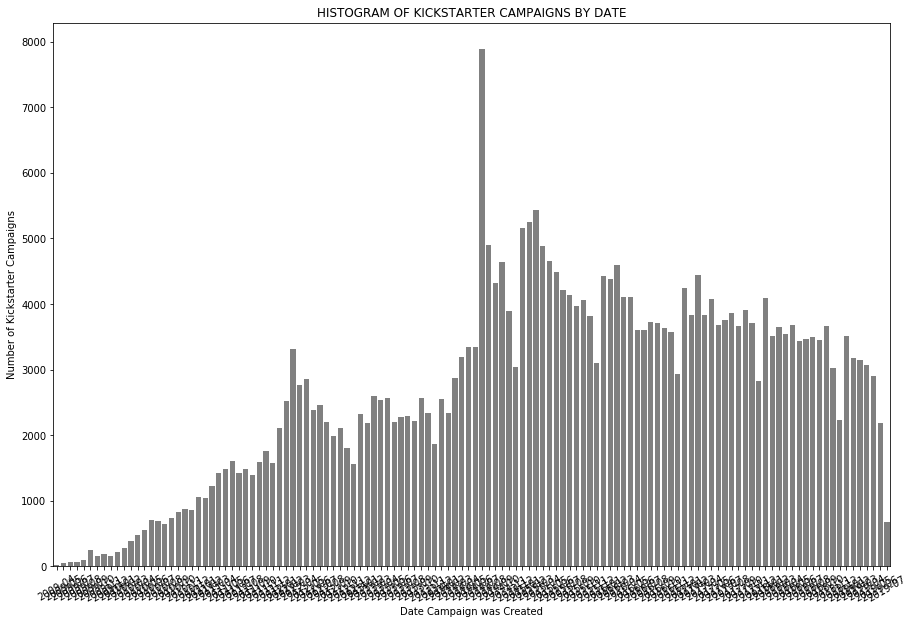

In [8]:
kick_inter['year_month'] = pd.to_datetime(kick_inter['created_at']).dt.to_period('M')
created_date_count = kick_inter.year_month.value_counts().to_frame().reset_index().rename(columns={'index':'date', 
                                                                                                   'year_month': 'count'})
created_date_count.sort_values(by='date', inplace=True)
# average number of campaings launched each month
print('Average Number of Campaigns Launched Each Month: ', np.round(created_date_count['count'].mean()))
plt.figure(figsize=[15,10])
ax = sns.barplot(created_date_count['date'], created_date_count['count'], color='grey')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.xlabel("Date Campaign was Created")
plt.ylabel("Number of Kickstarter Campaigns")
plt.title('HISTOGRAM OF KICKSTARTER CAMPAIGNS BY DATE')

plt.show()

#### Goal & FX Rate

The goal feature is in 14 different currencies (with USD and GBP as the most frequent). In order to build a model, we are going to have to convert all goal amounts to the same scale (USD) so that our model can interpret the feature correctly. 

In [9]:
kick_inter[['goal', 'fx_rate', 'currency']].head(10)

,goal,fx_rate,currency
0,5000.0,1.000000,USD
1,5000.0,1.000000,USD
2,5000.0,0.766388,CAD
3,3500.0,1.000000,USD
4,2000.0,1.000000,USD
5,35932.0,0.681983,CAD
6,500.0,1.000000,USD
7,6800.0,1.000000,USD
8,600.0,1.000000,USD
9,4000.0,1.000000,USD


In [10]:
kick_deduped.currency.value_counts()

USD    244692
GBP     32424
EUR     21221
CAD     14335
AUD      7556
MXN      3201
SEK      2030
HKD      1513
NZD      1414
DKK      1252
SGD      1087
CHF       987
NOK       752
JPY       435
Name: currency, dtype: int64

#### Sub category & Overall category  

Kickstarter campaigns fall into 1 of over 170 different overall categories and any number of 159 different sub-categories. The information both columns is repetitive. Since the sub-category has more specific information, I'd like to retain this category for further analysis. 

In [11]:
kick_inter[['sub_category', 'overall_category']].head()

,sub_category,overall_category
0,Apparel,fashion/apparel
1,Tabletop Games,games/tabletop games
2,Fashion,fashion
3,Music,music
4,Drama,film & video/drama


In [12]:
print('Number of Categories in the "overall_category" column: ',kick_inter['overall_category'].nunique())

Number of Categories in the "overall_category" column:  170


In [13]:
print('Top 10 categories in Overall Category Column: \n \n',kick_inter['overall_category'].value_counts().head(5))

Top 10 categories in Overall Category Column: 
 
 design/product design    18839
games/tabletop games     15431
games/video games        10717
publishing/fiction        8906
fashion/apparel           8881
Name: overall_category, dtype: int64


In [14]:
print('Number of Categories in the "sub_category" column: ',kick_inter['sub_category'].nunique())

Number of Categories in the "sub_category" column:  159


In [15]:
print('Top 10 categories in Sub-Category Column: \n \n',kick_inter['sub_category'].value_counts().head(5))

Top 10 categories in Sub-Category Column: 
 
 Product Design    18839
Tabletop Games    15431
Video Games       10717
Fiction            8906
Apparel            8881
Name: sub_category, dtype: int64


Of the top 5 Sub-catagories for product design, 100% of all product design campaigns have been successfull, while around 37% of tabletop games have been successful. 

In [16]:
mask_successful_proddesign = (kick_inter['state']=='successful') & (kick_inter['sub_category']=='Product Design')
mask_all_productdesign = ((kick_inter['sub_category']=='Product Design') & ((kick_inter['state']=='successful') | (kick_inter['state']=='failed')))
print('Total number of campaigns classified as product design: ',len(kick_inter.loc[mask_all_productdesign]))
print('Ratio of successful Product Design Campaigns: ',len(kick_inter.loc[mask_successful_proddesign])/len(kick_inter.loc[mask_all_productdesign]))
print('\n')

mask_successful_tabletopgames = (kick_inter['state']=='successful') & (kick_inter['sub_category']=='Video Games')
mask_all_tabletopgames = ((kick_inter['sub_category']=='Video Games') & ((kick_inter['state']=='successful') | (kick_inter['state']=='failed')))

print('Total Number of campaigns classified as Tabletop Games: ', len(kick_inter.loc[mask_all_tabletopgames]))
print('Ratio of Successful Tabletop Game Campaigns: ',len(kick_inter.loc[mask_successful_tabletopgames])/len(kick_inter.loc[mask_all_tabletopgames]))

Total number of campaigns classified as product design:  10629
Ratio of successful Product Design Campaigns:  1.0


Total Number of campaigns classified as Tabletop Games:  7855
Ratio of Successful Tabletop Game Campaigns:  0.3689369828134946


#### Location (city/ state/ country)  

A location feature could be useful in predicting success of kickstarter campaigns. There are 211 countries represented in the dataset and over 12K cities. This column will need to be turned into a dummy variable for the models so city is too large. We will go with the country column for now and consider grouping this column into region). 

In [17]:
kick_inter[['city', 'country_loc', 'state_loc']].head()

,city,country_loc,state_loc
0,Wasilla,US,AK
1,Holland,US,MI
2,Toronto,CA,ON
3,Saratoga Springs,US,NY
4,Nashville,US,TN


In [18]:
print('Number of Countries that have produced a Kickstarter campaing: ', kick_inter.country_loc.nunique())
print('Number of Cities that have produced a Kickstarter Campaign: ', kick_inter.city.nunique())
print('Number of states that have produced a Kickstarter Campaign: ', kick_inter.state.nunique())

Number of Countries that have produced a Kickstarter campaing:  211
Number of Cities that have produced a Kickstarter Campaign:  12685
Number of states that have produced a Kickstarter Campaign:  5


## FEATURE CONSTRUCTION

After taking a look at the columns in our dataset, we have narrowed down the final list of features to train our models on. 

**Final Features**
1. Blurb word count
1. Campaign length 
1. Currency
1. Goal (converted to USD) 
1. Delta between created_at and launched_at column
1. Sub category 
1. Country
1. group cluster (KNN) 
1. **state** [Target Variable]

#### Create Imputed columns

The kickstarter intermediate dataset is processed through calling the kickstarter_feature_engineering function (found in the "src/d03_processing folder". 

In [19]:
kick_proc = kickstarter_feature_engineering(kick_inter)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/markishab/coding_projects/python_projects/flatiron_school/projects/supervised-classification/notebooks/04_reports/../../src/d03_processing/feature_engineering.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kick_inter['blurb_word_count'] = kick_inter.blurb.str.split().str.len()
/Users/markishab/coding_projects/python_projects/flatiron_school/projects/supervised-classification/notebooks/04_reports/../../src/d03_processing/feature

#### Read in Cluster feature Dataset

In [20]:
cluster_features =  pd.read_csv('../../data/03_processed/KNN_cluster_features_.csv')
kick_proc = kick_proc.merge(cluster_features, 
                           how='left', 
                           on='id')

In [21]:
kick_proc.head()

,currency,goal_original,id,category,country,year_month,blurb_word_count,campaign_length,delta_created_launched,goal_usd,successful_dummy,world_regions,cluster_predictions
0,USD,5000.0,1175125319,Tabletop Games,US,2019-06,9.0,32,13,5000.0,1,Northern America,3.0
1,USD,3500.0,920424993,Music,US,2019-06,14.0,18,1,3500.0,1,Northern America,0.0
2,USD,500.0,1253520992,Zines,US,2019-07,17.0,15,1,500.0,1,Northern America,3.0
3,USD,6800.0,335137457,Graphic Novels,US,2019-06,12.0,30,6,6800.0,1,Northern America,2.0
4,USD,600.0,58084093,Mixed Media,US,2019-06,19.0,30,0,600.0,1,Northern America,2.0


## MODEL EXPLORATION & TUNING

In [101]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

It's now time to build our first model. Because we are making decisions about what campaigns to spotlight and contact for additional help, which will cost Kickstarter money and time, we want to go with a model that has the lowest number of false positives(i.e., the model with the lowest number of campaigns that are falsely identified as successful). Because of this, we will be maximizing our model for precision. 

### Baseline Model - Decision Tree

#### Set-up train & testing data

Let's drop any remaining null values. 

In [232]:
print('Number of Rows before dropping NAs: ',len(kick_proc))
kick_proc.dropna(inplace=True)

Number of Rows before dropping NAs:  275642


In [233]:
print('Number of Rows after dropping NAs: ',len(kick_proc))

Number of Rows after dropping NAs:  275642


In [234]:
y = kick_proc['successful_dummy']
df_no_y = kick_proc.drop('successful_dummy', axis=1)
X_feats = ['category', 'blurb_word_count', 'campaign_length',
           'delta_created_launched', 'goal_usd','world_regions', 
           'cluster_predictions']
X = pd.get_dummies(df_no_y[X_feats])

We now have over 187 predictor variables (after making category and world region dummy variables). 

In [111]:
X.shape

(275642, 187)

Out outcome variable is also relatively balanced. We will not use any re-balancing techniques for now. 

In [112]:
y.value_counts()

1    146584
0    129058
Name: successful_dummy, dtype: int64

Let's split our data into training and testing sets and stratify on y to ensure that our test and train set outcomes are balanced. 

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print('Train Set: \n', y_train.value_counts()/len(y_train))
print('\n')
print('Test Set: \n', y_test.value_counts()/len(y_test))

Train Set: 
 1    0.531793
0    0.468207
Name: successful_dummy, dtype: float64


Test Set: 
 1    0.531787
0    0.468213
Name: successful_dummy, dtype: float64


#### Instantiate and learn our decision tree model

Our out of the box decision tree model has a precision score of around 72%. Let's try and build a model that does better than this. 

In [140]:
dtc = DecisionTreeClassifier(random_state=88)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=88, splitter='best')

In [141]:
y_pred_dt = dtc.predict(X_test)
print('Accuracy score of basic decision tree model: {}%'.format(accuracy_score(y_test, y_pred_dt)*100))
print('Precision score of basic decision Tree Model: {}%'.format(precision_score(y_test, y_pred_dt)*100))

Accuracy score of basic decision tree model: 70.32259000740085%
Precision score of basic decision Tree Model: 72.29303746937202%


In [116]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_dt), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,22178,10087
actual 1,10368,26278


### Bagging Model - Random Forest

In [49]:
steps = [('rfc', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rfc__n_estimators':list(range(1, 200, 5)), 
             'rfc__criterion': ['gini', 'entropy'], 
             'rfc__max_depth': list(range(1, 10, 1)), 
             'rfc__min_samples_split': list(range(2, 10, 1)), 
             'rfc__min_samples_leaf': list(range(1, 5, 1))}

randomCV = RandomizedSearchCV(pipeline, parameters, cv=10)

randomCV.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('rfc',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     min_impurity_decrease=0.0,
                                                                     min_impurity_split=None,
                                                                     min_samples_leaf=1,
                                 

In [50]:
randomCV.best_params_

{'rfc__n_estimators': 141,
 'rfc__min_samples_split': 7,
 'rfc__min_samples_leaf': 1,
 'rfc__max_depth': 9,
 'rfc__criterion': 'entropy'}

#### Train our Best Random Forest Model

In [142]:
final_rfm = RandomForestClassifier(n_estimators=141, 
                                   min_samples_split=7, 
                                   min_samples_leaf=1,
                                   max_depth=9,
                                   criterion='entropy', 
                                  random_state=88)
final_rfm.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=141,
                       n_jobs=None, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

#### Test our best random forest model

In [143]:
y_pred_rfm = final_rfm.predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_rfm), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,20249,12016
actual 1,6863,29783


In [144]:
print('Accuracy of Random Forest Model: {}%'.format(accuracy_score(y_test, y_pred_rfm)*100))
print('Precision of Random Forest Model: {}%'.format(precision_score(y_test, y_pred_rfm)*100))

Accuracy of Random Forest Model: 72.60379329860255%
Precision of Random Forest Model: 71.25290078710017%


### Boosting Models - Adaboost

#### Find best parameters 

In [60]:
# set parameters to test in the randomized search 
params = {'n_estimators': list(np.arange(50, 200, 10))}

# instantiate randomized search with Adaboost classifier
randomABCV = RandomizedSearchCV(AdaBoostClassifier(), params, cv=5)

# fit the model
randomABCV.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'n_estimators': [50, 60, 70, 80, 90,
                                                         100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                                         180, 190]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [61]:
randomABCV.best_params_

{'n_estimators': 190}

#### Train our best adaboost model  

In [145]:
final_abm = AdaBoostClassifier(n_estimators=190, 
                              random_state=88)
final_abm.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=190, random_state=88)

#### Test our best adaboost model

In [146]:
y_pred_ab = final_abm.predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_ab), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,25673,6592
actual 1,9437,27209


In [147]:
print('Accuracy of Adaboost Model: {}%'.format(accuracy_score(y_test, y_pred_ab)*100))
print('Precision of Adaboost Model: {}%'.format(precision_score(y_test, y_pred_ab)*100))

Accuracy of Adaboost Model: 76.73956262425448%
Precision of Adaboost Model: 80.4976184136564%


### Logistic Regression Model  

In [74]:
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

randomLR = RandomizedSearchCV(LogisticRegression(), hyperparameters, cv=5)
randomLR.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                                        'pen

In [75]:
randomLR.best_params_

{'penalty': 'l1', 'C': 3593.813663804626}

In [148]:
final_lrm = LogisticRegression(penalty='l1', 
                               C=3593.813663804626, 
                              random_state=88)
final_lrm.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=3593.813663804626, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=88, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [149]:
y_pred_lr = final_lrm.predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_lr), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,25794,6471
actual 1,10959,25687


In [150]:
print('Accuracy of Logistic Regression Model: {}%'.format(accuracy_score(y_test, y_pred_lr)*100))
print('Precision of Logistic Regression Model: {}%'.format(precision_score(y_test, y_pred_lr)*100))

Accuracy of Logistic Regression Model: 74.70650549259189%
Precision of Logistic Regression Model: 79.87747994278251%


### Gaussian Naive Bayes

In [124]:
final_nbG = GaussianNB()
final_nbG.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [128]:
y_pred_nbg = final_lrm.predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_nbg), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,25799,6466
actual 1,10983,25663


In [129]:
print('Accuracy of Gaussian Naive Bayes Model: {}%'.format(accuracy_score(y_test, y_pred_nbg)*100))
print('Precision of Gaussian Naive Bayes Model: {}%'.format(precision_score(y_test, y_pred_nbg)*100))

Accuracy of Gaussian Naive Bayes Model: 74.67893369708754%
Precision of Gaussian Naive Bayes Model: 79.87487939244919%


### Bernoulli Naive Bayes

In [130]:
final_nbB = BernoulliNB()
final_nbB.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [131]:
y_pred_nbb = final_nbB.predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_nbb), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,25596,6669
actual 1,11521,25125


In [132]:
print('Accuracy of Bernoulli Naive Bayes Model: {}%'.format(accuracy_score(y_test, y_pred_nbb)*100))
print('Precision of Bernoulli Naive Bayes Model: {}%'.format(precision_score(y_test, y_pred_nbb)*100))

Accuracy of Bernoulli Naive Bayes Model: 73.60363367241804%
Precision of Bernoulli Naive Bayes Model: 79.02434421588978%


## MODEL SELECTION

Because we are interested in maximizing our precision for this particular model we will choose the model with the highest precision score. After testing 6 different learning algorithms and utilizing random grid search to find the best parameters, the Adaboost model produced the highest precision score with over 80% accuracy with testing data. The two naive bayes models were not far behind with precision scores of around 79% 

In [151]:
print('--------------------DECISION TREE MODEL STATS-----------------------')
print('Accuracy score of basic decision tree model: {}%'.format(accuracy_score(y_test, y_pred_dt)*100))
print('Precision score of basic decision Tree Model: {}%'.format(precision_score(y_test, y_pred_dt)*100))
print('\n')

print('--------------------RANDOM FOREST MODEL STATS-----------------------')
print('Accuracy of Random Forest Model: {}%'.format(accuracy_score(y_test, y_pred_rfm)*100))
print('Precision of Random Forest Model: {}%'.format(precision_score(y_test, y_pred_rfm)*100))
print('\n')

print('--------------------ADABOOST MODEL STATS-----------------------')
print('Accuracy of Adaboost Model: {}%'.format(accuracy_score(y_test, y_pred_ab)*100))
print('Precision of Adaboost Model: {}%'.format(precision_score(y_test, y_pred_ab)*100))
print('\n')

print('--------------------LOGISTIC REGRESSION MODEL STATS-----------------------')
print('Accuracy of Logistic Regression Model: {}%'.format(accuracy_score(y_test, y_pred_lr)*100))
print('Precision of Logistic Regression Model: {}%'.format(precision_score(y_test, y_pred_lr)*100))
print('\n')

print('--------------------GAUSSIAN NAIVE BAYES MODEL STATS-----------------------')
print('Accuracy of Gaussian Naive Bayes Model: {}%'.format(accuracy_score(y_test, y_pred_nbg)*100))
print('Precision of Gaussian Naive Bayes Model: {}%'.format(precision_score(y_test, y_pred_nbg)*100))
print('\n')

print('--------------------BERNOULLI NAIVE BAYES MODEL STATS-----------------------')
print('Accuracy of Bernoulli Naive Bayes Model: {}%'.format(accuracy_score(y_test, y_pred_nbb)*100))
print('Precision of Bernoulli Naive Bayes Model: {}%'.format(precision_score(y_test, y_pred_nbb)*100))

--------------------DECISION TREE MODEL STATS-----------------------
Accuracy score of basic decision tree model: 70.32259000740085%
Precision score of basic decision Tree Model: 72.29303746937202%


--------------------RANDOM FOREST MODEL STATS-----------------------
Accuracy of Random Forest Model: 72.60379329860255%
Precision of Random Forest Model: 71.25290078710017%


--------------------ADABOOST MODEL STATS-----------------------
Accuracy of Adaboost Model: 76.73956262425448%
Precision of Adaboost Model: 80.4976184136564%


--------------------LOGISTIC REGRESSION MODEL STATS-----------------------
Accuracy of Logistic Regression Model: 74.70650549259189%
Precision of Logistic Regression Model: 79.87747994278251%


--------------------GAUSSIAN NAIVE BAYES MODEL STATS-----------------------
Accuracy of Gaussian Naive Bayes Model: 74.67893369708754%
Precision of Gaussian Naive Bayes Model: 79.87487939244919%


--------------------BERNOULLI NAIVE BAYES MODEL STATS--------------------

## Test run on our chosen model

In [176]:
import random

Let's go back to our original dataset and find the campaigns that were marked as live during the time of data collection. 

In [153]:
print('Latest Datapoint for the Model Training: ',
      latest_model_data.sort_values(by=['deadline'], 
                                    ascending=False).head(1)['deadline'])

Latest Datapoint for the Model Training:  1   2019-07-18 03:55:00
Name: deadline, dtype: datetime64[ns]


Import and process the campaigns marked as 'live' from our original dataset. 

In [172]:
kick_live_proc = kickstarter_live_campaign_data_cleaning(kick_inter)

#### Let's make a random list of live campaigns to predict on

In [271]:
random.seed(88)
list_ids = list(kick_live_proc['id'])
ids = random.sample(list_ids, 
                    10)

campaigns_to_predict_on = kick_live_proc.loc[(kick_live_proc['id'].isin(ids))]
campaigns_to_predict_on.reset_index(inplace=True, drop=True)
campaigns_to_predict_on

,blurb,currency,deadline,goal_original,id,name,target,urls,category,country,year_month,blurb_word_count,campaign_length,delta_created_launched,goal_usd,world_regions
0,"Murder, regret and possession push a Pinkerton...",USD,2019-07-30 18:24:36,1000.0,676225315,The Dark Gun #3,live,"{""web"":{""project"":""https://www.kickstarter.com...",Comic Books,US,2019-07,22,15,5,1000.000000,Northern America
1,The online market place for Eco-friendly produ...,GBP,2019-08-03 14:30:00,6995.0,1423959699,Born-Eco. The Eco-friendly market place.,live,"{""web"":{""project"":""https://www.kickstarter.com...",Web,GB,2019-06,7,31,26,8700.540906,Northern Europe
2,"A short film about family, love, loss, and ove...",USD,2019-07-31 03:59:00,3000.0,1356843955,Short Film: Leave This,live,"{""web"":{""project"":""https://www.kickstarter.com...",Drama,US,2019-06,24,28,3,3000.000000,Northern America
3,SquashPod® is a simple multi-functional and ad...,GBP,2019-07-28 18:01:13,15000.0,1499346107,SquashPod® - the Original Pocket Container,live,"{""web"":{""project"":""https://www.kickstarter.com...",Product Design,GB,2019-05,14,30,28,18622.505700,Northern Europe
4,An alternative to notoriously filthy shower lo...,USD,2019-08-02 00:00:00,14000.0,1737371411,"Sud Stud: A Simple, Intelligently Designed Sho...",live,"{""web"":{""project"":""https://www.kickstarter.com...",Gadgets,US,2019-04,18,36,76,14000.000000,Northern America
5,A streetwear line from Kenya bringing traditio...,GBP,2019-07-21 16:30:06,500.0,464408344,Setutsi: luxury streetwear honouring African h...,live,"{""web"":{""project"":""https://www.kickstarter.com...",Fashion,KE,2019-06,14,30,4,621.911430,Eastern Africa
6,"A 500 ml hand blown decanter, encased in 2 sta...",USD,2019-07-22 02:30:00,24000.0,1532230190,"Travel Decanter | Preserve Your Whiskey, Cockt...",live,"{""web"":{""project"":""https://www.kickstarter.com...",Product Design,US,2019-04,22,33,54,24000.000000,Northern America
7,Help us bring this inspiring story about gende...,EUR,2019-08-04 10:18:30,15000.0,2098467590,LOTUS SPORTS CLUB - A documentary about LGBTQI...,live,"{""web"":{""project"":""https://www.kickstarter.com...",Documentary,KH,2019-05,17,56,38,16940.117850,South-eastern Asia
8,Help create an eco-friendly surf school that r...,EUR,2019-07-23 13:23:22,31500.0,464038277,Eco Friendly Surf School,live,"{""web"":{""project"":""https://www.kickstarter.com...",Civic Design,ES,2018-10,21,50,220,35574.247485,Southern Europe
9,LA VOZ debe seguir oyéndose porque es un progr...,USD,2019-07-19 10:58:56,85000.0,1207994101,LA VOZ de César Vidal - 2019 / 2020,live,"{""web"":{""project"":""https://www.kickstarter.com...",Audio,US,2019-05,21,60,3,85000.000000,Northern America


In [272]:
X_feats = ['category', 'blurb_word_count', 'campaign_length',
           'delta_created_launched', 'goal_usd', 'world_regions']
X_live_pred = pd.get_dummies(campaigns_to_predict_on[X_feats])
model_features = list(X.columns)

In [273]:
X_lp_final = prepare_missing_adaboost_columns(X_live_pred, model_features, 10)

In [274]:
y_pred_live = final_abm.predict(X_lp_final)
campaigns_to_predict_on['predictions'] = y_pred_live
campaigns_to_predict_on[['id', 'urls','name', 'category', 'year_month', 'goal_usd', 'predictions']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,urls,name,category,year_month,goal_usd,predictions
0,676225315,"{""web"":{""project"":""https://www.kickstarter.com...",The Dark Gun #3,Comic Books,2019-07,1000.000000,0
1,1423959699,"{""web"":{""project"":""https://www.kickstarter.com...",Born-Eco. The Eco-friendly market place.,Web,2019-06,8700.540906,1
2,1356843955,"{""web"":{""project"":""https://www.kickstarter.com...",Short Film: Leave This,Drama,2019-06,3000.000000,0
3,1499346107,"{""web"":{""project"":""https://www.kickstarter.com...",SquashPod® - the Original Pocket Container,Product Design,2019-05,18622.505700,1
4,1737371411,"{""web"":{""project"":""https://www.kickstarter.com...","Sud Stud: A Simple, Intelligently Designed Sho...",Gadgets,2019-04,14000.000000,1
5,464408344,"{""web"":{""project"":""https://www.kickstarter.com...",Setutsi: luxury streetwear honouring African h...,Fashion,2019-06,621.911430,0
6,1532230190,"{""web"":{""project"":""https://www.kickstarter.com...","Travel Decanter | Preserve Your Whiskey, Cockt...",Product Design,2019-04,24000.000000,1
7,2098467590,"{""web"":{""project"":""https://www.kickstarter.com...",LOTUS SPORTS CLUB - A documentary about LGBTQI...,Documentary,2019-05,16940.117850,0
8,464038277,"{""web"":{""project"":""https://www.kickstarter.com...",Eco Friendly Surf School,Civic Design,2018-10,35574.247485,0
9,1207994101,"{""web"":{""project"":""https://www.kickstarter.com...",LA VOZ de César Vidal - 2019 / 2020,Audio,2019-05,85000.000000,0


In [286]:
# went through all campaign links (found in URL column) and checked the real world outcome of each cammpaigne44sw
outcomes = [1, 0, 0, np.nan, 1, 0, 1, 1, 0, 1]
campaigns_to_predict_on['outcomes'] = outcomes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [291]:
campaigns_to_predict_on

,blurb,currency,deadline,goal_original,id,name,target,urls,category,country,year_month,blurb_word_count,campaign_length,delta_created_launched,goal_usd,world_regions,predictions,outcomes
0,"Murder, regret and possession push a Pinkerton...",USD,2019-07-30 18:24:36,1000.0,676225315,The Dark Gun #3,live,"{""web"":{""project"":""https://www.kickstarter.com...",Comic Books,US,2019-07,22,15,5,1000.000000,Northern America,0,1.0
1,The online market place for Eco-friendly produ...,GBP,2019-08-03 14:30:00,6995.0,1423959699,Born-Eco. The Eco-friendly market place.,live,"{""web"":{""project"":""https://www.kickstarter.com...",Web,GB,2019-06,7,31,26,8700.540906,Northern Europe,1,0.0
2,"A short film about family, love, loss, and ove...",USD,2019-07-31 03:59:00,3000.0,1356843955,Short Film: Leave This,live,"{""web"":{""project"":""https://www.kickstarter.com...",Drama,US,2019-06,24,28,3,3000.000000,Northern America,0,0.0
3,SquashPod® is a simple multi-functional and ad...,GBP,2019-07-28 18:01:13,15000.0,1499346107,SquashPod® - the Original Pocket Container,live,"{""web"":{""project"":""https://www.kickstarter.com...",Product Design,GB,2019-05,14,30,28,18622.505700,Northern Europe,1,NaN
4,An alternative to notoriously filthy shower lo...,USD,2019-08-02 00:00:00,14000.0,1737371411,"Sud Stud: A Simple, Intelligently Designed Sho...",live,"{""web"":{""project"":""https://www.kickstarter.com...",Gadgets,US,2019-04,18,36,76,14000.000000,Northern America,1,1.0
5,A streetwear line from Kenya bringing traditio...,GBP,2019-07-21 16:30:06,500.0,464408344,Setutsi: luxury streetwear honouring African h...,live,"{""web"":{""project"":""https://www.kickstarter.com...",Fashion,KE,2019-06,14,30,4,621.911430,Eastern Africa,0,0.0
6,"A 500 ml hand blown decanter, encased in 2 sta...",USD,2019-07-22 02:30:00,24000.0,1532230190,"Travel Decanter | Preserve Your Whiskey, Cockt...",live,"{""web"":{""project"":""https://www.kickstarter.com...",Product Design,US,2019-04,22,33,54,24000.000000,Northern America,1,1.0
7,Help us bring this inspiring story about gende...,EUR,2019-08-04 10:18:30,15000.0,2098467590,LOTUS SPORTS CLUB - A documentary about LGBTQI...,live,"{""web"":{""project"":""https://www.kickstarter.com...",Documentary,KH,2019-05,17,56,38,16940.117850,South-eastern Asia,0,1.0
8,Help create an eco-friendly surf school that r...,EUR,2019-07-23 13:23:22,31500.0,464038277,Eco Friendly Surf School,live,"{""web"":{""project"":""https://www.kickstarter.com...",Civic Design,ES,2018-10,21,50,220,35574.247485,Southern Europe,0,0.0
9,LA VOZ debe seguir oyéndose porque es un progr...,USD,2019-07-19 10:58:56,85000.0,1207994101,LA VOZ de César Vidal - 2019 / 2020,live,"{""web"":{""project"":""https://www.kickstarter.com...",Audio,US,2019-05,21,60,3,85000.000000,Northern America,0,1.0


In [296]:
print('Overall accuracy of "live" predictions: {}%'.format((5/9)*100))
print('Ratio of of actually successful campaings out of total number of campaings predicted to be successful: 2/3')

Overall accuracy of "live" predictions: 55.55555555555556%
Ratio of of actually successful campaings out of total number of campaings predicted to be successful: 2/3


## CONCLUSION & NEXT STEPS 

Although our chosen model had an accuracy of around 80% on our test dataset, the accuracy of our final model on a small sample of real world data was only 55%. One positive note was that out of the three campaigns our model predicted to be successful, 2 of them were indeed successful. 